In [2]:
import pandas as pd
from ete3 import NCBITaxa
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from scipy.stats import spearmanr

In [3]:
ncbi = NCBITaxa()

In [4]:
df = pd.read_csv('./data_blast.csv')
df["species"] = df["species"].str.replace("_", " ", regex=False)
df.head()

,family,id_clean,species,family_id,true_label,prediction,correct
0,Dof,XP_009624330.1,Nicotiana tomentosiformis,1,1,1,1
1,Dof,Csa10g022470.1,Camelina sativa,1,1,1,1
2,Dof,C.cajan_17965,Cajanus cajan,1,1,1,1
3,Dof,EPS59263.1,Genlisea aurea,1,1,1,1
4,Dof,WALNUT_00012687-RA,Juglans regia,1,1,1,1


In [5]:
species_list = df["species"].unique().tolist()

In [6]:
name2taxid = {}
for sp in species_list:
    try:
        taxid = ncbi.get_name_translator([sp])[sp][0]
        name2taxid[sp] = taxid
    except KeyError:
        print(f"⚠️ Species not found: {sp}")


⚠️ Species not found: Chlorella variabilis NC64A
⚠️ Species not found: Micromonas sp. RCC299


In [7]:
df = df[~df["species"].isin(["Chlorella variabilis NC64A", "Micromonas sp. RCC299"])]

In [8]:
tree = ncbi.get_topology(list(name2taxid.values()))
tree.ladderize()

164

In [26]:
tree.show()

In [9]:


distances = []

# Iterate over all unique species pairs
for sp1, sp2 in combinations(name2taxid.keys(), 2):
    node1 = tree&str(name2taxid[sp1])
    node2 = tree&str(name2taxid[sp2])
    d = tree.get_distance(node1, node2)
    distances.append({
        "species1": sp1,
        "species2": sp2,
        "distance": d
    })

phylo_df = pd.DataFrame(distances)
print(f"✅ Computed {len(phylo_df)} pairwise distances.")
phylo_df.head()

✅ Computed 13366 pairwise distances.


,species1,species2,distance
0,Nicotiana tomentosiformis,Camelina sativa,12.0
1,Nicotiana tomentosiformis,Cajanus cajan,12.0
2,Nicotiana tomentosiformis,Genlisea aurea,7.0
3,Nicotiana tomentosiformis,Juglans regia,10.0
4,Nicotiana tomentosiformis,Nicotiana sylvestris,2.0


In [10]:
species_accuracy = df.groupby("species")["correct"].mean().reset_index(name="accuracy")
species_accuracy.head()

,species,accuracy
0,Actinidia chinensis,0.864444
1,Aegilops tauschii,0.887719
2,Aethionema arabicum,0.830189
3,Amaranthus hypochondriacus,0.844221
4,Amborella trichopoda,0.813665


In [11]:

merged = phylo_df.merge(
    species_accuracy.rename(columns={"species": "species1"}),
    on="species1",
    how="left"
).merge(
    species_accuracy.rename(columns={"species": "species2", "accuracy": "accuracy2"}),
    on="species2",
    how="left"
)

# Compute absolute accuracy difference between pairs
merged["accuracy_diff"] = abs(merged["accuracy"] - merged["accuracy2"])

rho, pval = spearmanr(merged["distance"], merged["accuracy_diff"])
print(f"Spearman correlation = {rho:.3f}, p = {pval:.4f}")


Spearman correlation = 0.078, p = 0.0000


In [12]:
merged.head()

,species1,species2,distance,accuracy,accuracy2,accuracy_diff
0,Nicotiana tomentosiformis,Camelina sativa,12.0,0.838284,0.853050,0.014766
1,Nicotiana tomentosiformis,Cajanus cajan,12.0,0.838284,0.841432,0.003148
2,Nicotiana tomentosiformis,Genlisea aurea,7.0,0.838284,0.843137,0.004853
3,Nicotiana tomentosiformis,Juglans regia,10.0,0.838284,0.820423,0.017861
4,Nicotiana tomentosiformis,Nicotiana sylvestris,2.0,0.838284,0.859504,0.021220


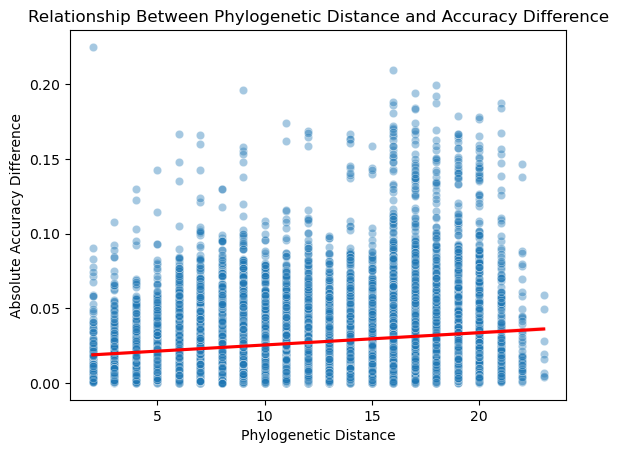

In [13]:


sns.scatterplot(data=merged, x="distance", y="accuracy_diff", alpha=0.4)
sns.regplot(data=merged, x="distance", y="accuracy_diff", scatter=False, color="red")
plt.xlabel("Phylogenetic Distance")
plt.ylabel("Absolute Accuracy Difference")
plt.title("Relationship Between Phylogenetic Distance and Accuracy Difference")
plt.show()


/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


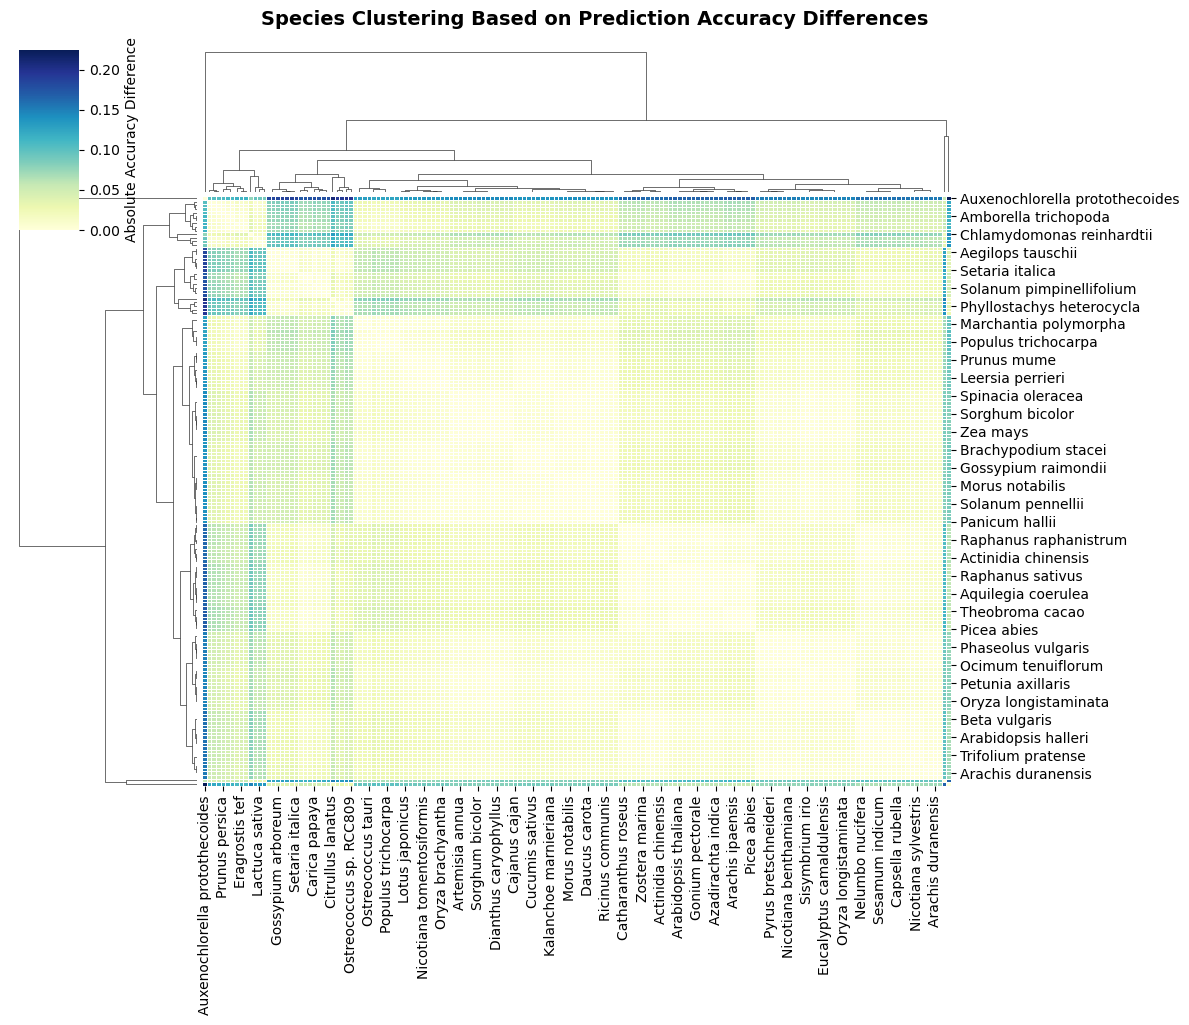

In [14]:
pivot_df = merged.pivot(index="species1", columns="species2", values="accuracy_diff")

# Fill missing cells to make it symmetric
pivot_df = pivot_df.combine_first(pivot_df.T)

# Replace NaN with 0 (self-comparisons)
pivot_df.fillna(0, inplace=True)

# Plot clustered heatmap
sns.clustermap(
    pivot_df,
    cmap="YlGnBu",        # or "coolwarm" for contrast
    figsize=(12, 10),
    linewidths=0.5,
    cbar_kws={'label': 'Absolute Accuracy Difference'},
)

plt.suptitle(
    "Species Clustering Based on Prediction Accuracy Differences",
    fontsize=14,
    weight="bold",
    y=1.02
)
plt.show()

/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


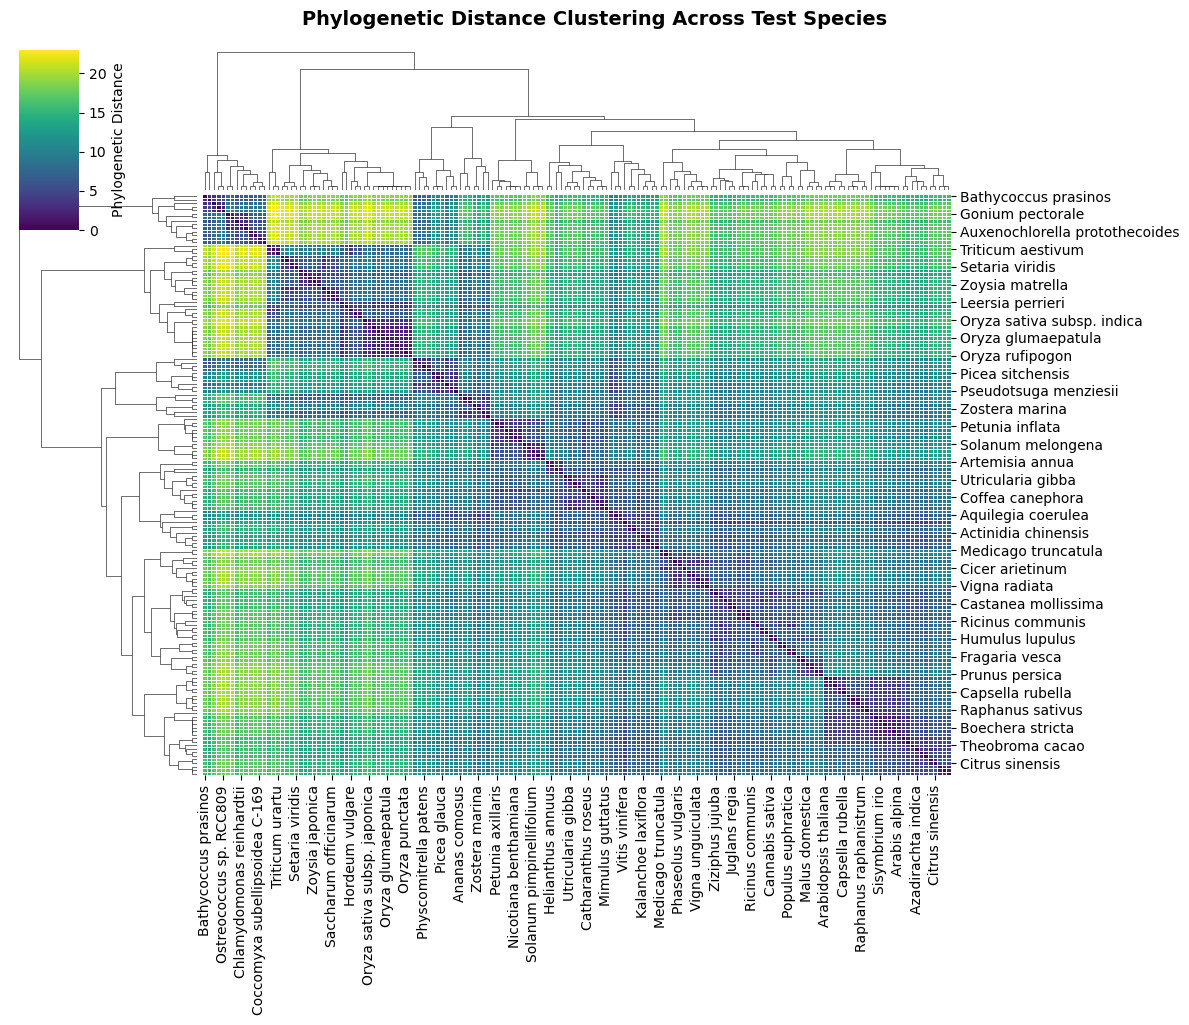

In [15]:
pivot_dist = merged.pivot(index="species1", columns="species2", values="distance")
pivot_dist = pivot_dist.combine_first(pivot_dist.T)
pivot_dist.fillna(0, inplace=True)

sns.clustermap(
    pivot_dist,
    cmap="viridis",
    figsize=(12, 10),
    linewidths=0.5,
    cbar_kws={'label': 'Phylogenetic Distance'}
)
plt.suptitle(
    "Phylogenetic Distance Clustering Across Test Species",
    fontsize=14,
    weight="bold",
    y=1.02
)
plt.show()


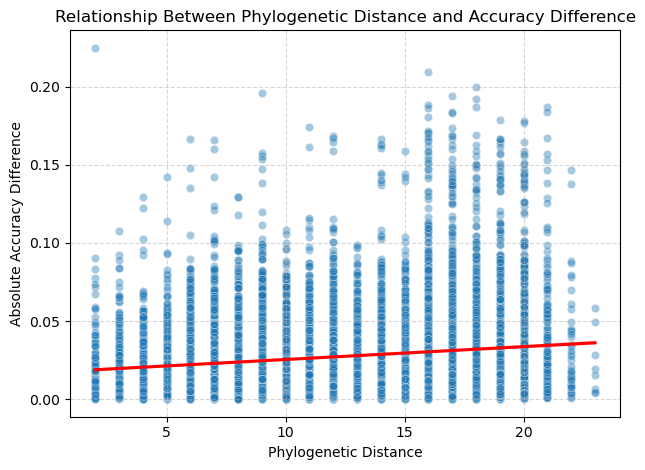

In [16]:
sns.scatterplot(data=merged, x="distance", y="accuracy_diff", alpha=0.4)
sns.regplot(data=merged, x="distance", y="accuracy_diff", scatter=False, color="red")
plt.xlabel("Phylogenetic Distance")
plt.ylabel("Absolute Accuracy Difference")
plt.title("Relationship Between Phylogenetic Distance and Accuracy Difference")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T/ipykernel_53275/905313644.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = merged.groupby("distance_bin")["accuracy_diff"].mean().reset_index()


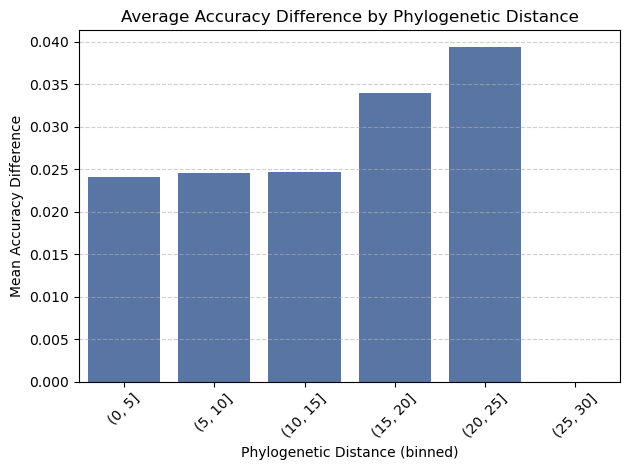

In [17]:
merged["distance_bin"] = pd.cut(merged["distance"], bins=[0,5,10,15,20,25,30])
bin_summary = merged.groupby("distance_bin")["accuracy_diff"].mean().reset_index()

sns.barplot(data=bin_summary, x="distance_bin", y="accuracy_diff", color="#4C72B0")
plt.title("Average Accuracy Difference by Phylogenetic Distance")
plt.xlabel("Phylogenetic Distance (binned)")
plt.ylabel("Mean Accuracy Difference")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/anaconda3/envs/MegaPlantTF/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


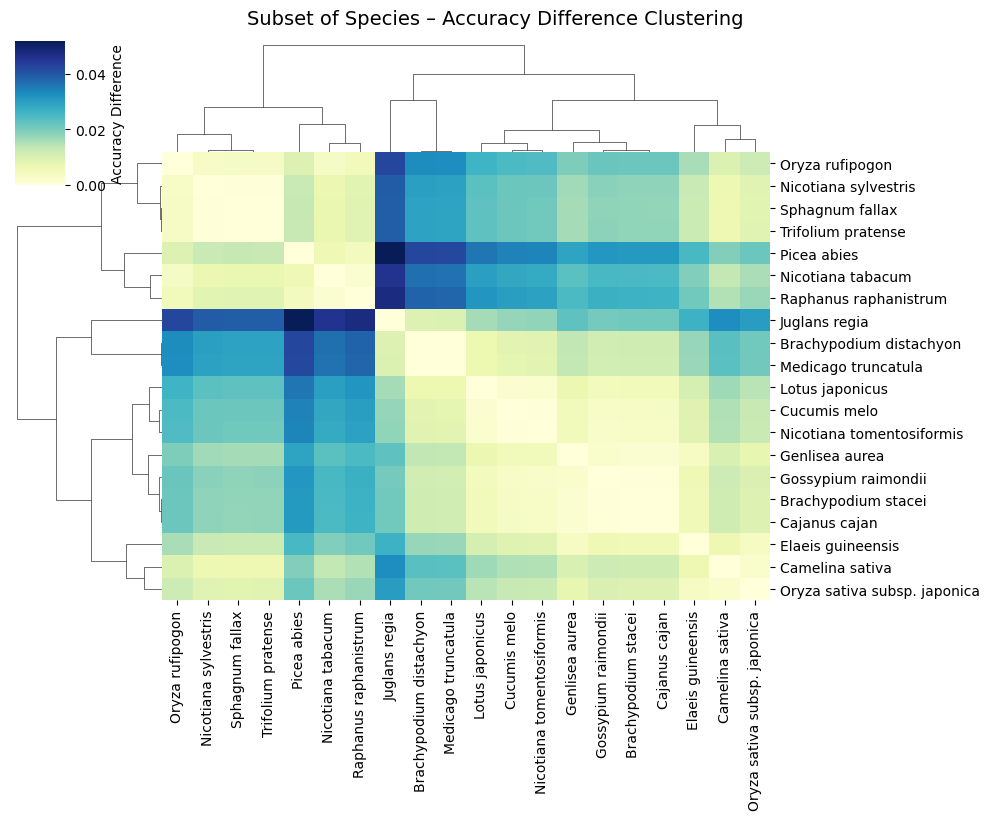

In [18]:
subset_species = merged["species1"].unique()[:20]  # or select manually by plant groups
subset = merged[merged["species1"].isin(subset_species) & merged["species2"].isin(subset_species)]
pivot_subset = subset.pivot(index="species1", columns="species2", values="accuracy_diff")
pivot_subset = pivot_subset.combine_first(pivot_subset.T).fillna(0)

sns.clustermap(pivot_subset, cmap="YlGnBu", figsize=(10,8), cbar_kws={'label': 'Accuracy Difference'})
plt.suptitle("Subset of Species – Accuracy Difference Clustering", fontsize=14, y=1.02)
plt.show()


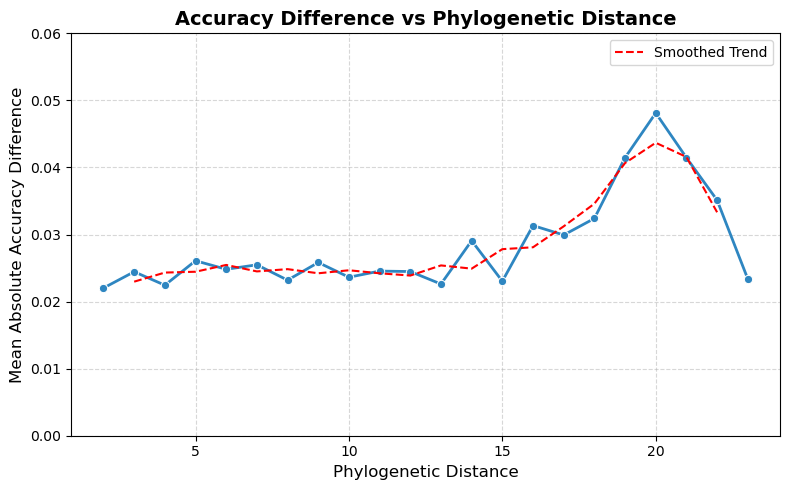

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sort your merged DataFrame by phylogenetic distance
merged_sorted = merged.sort_values(by="distance")

# Compute average accuracy difference per distance value (in case there are duplicates)
avg_diff = merged_sorted.groupby("distance", as_index=False)["accuracy_diff"].mean()

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=avg_diff,
    x="distance",
    y="accuracy_diff",
    marker="o",
    color="#2E86C1",
    linewidth=2
)

# Optional: add a rolling mean for smoother trend
avg_diff["smooth"] = avg_diff["accuracy_diff"].rolling(window=3, center=True).mean()
sns.lineplot(
    data=avg_diff,
    x="distance",
    y="smooth",
    color="red",
    linestyle="--",
    label="Smoothed Trend"
)

# --- Labels and style ---
plt.title("Accuracy Difference vs Phylogenetic Distance", fontsize=14, weight='bold')
plt.xlabel("Phylogenetic Distance", fontsize=12)
plt.ylabel("Mean Absolute Accuracy Difference", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 0.06)

plt.legend()
plt.tight_layout()

# --- Save high-quality figure ---
# plt.savefig(
#     "./accuracy_vs_distance_lineplot.png",
#     dpi=600,
#     bbox_inches="tight",
#     transparent=False
# )
plt.show()


In [20]:
import json
import os

os.makedirs("./results", exist_ok=True)
avg_diff["model"] = "BLAST"

output_path = "./results/BLAST_phylo.json"
avg_diff.to_json(output_path, orient="records", indent=4)
avg_diff.to_csv("./results/BLAST_phylo.csv", index=False)

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load both results
blast_df = pd.read_json("./results/BLAST_phylo.json")
mega_df = pd.read_json("./results/megaPlantTF_phylo.json")

# Merge into one DataFrame
combined_df = pd.concat([blast_df, mega_df], ignore_index=True)
combined_df.head()

,distance,accuracy_diff,smooth,model
0,2,0.022024,NaN,BLAST
1,3,0.024449,0.022973,BLAST
2,4,0.022446,0.024328,BLAST
3,5,0.026090,0.024451,BLAST
4,6,0.024817,0.025464,BLAST


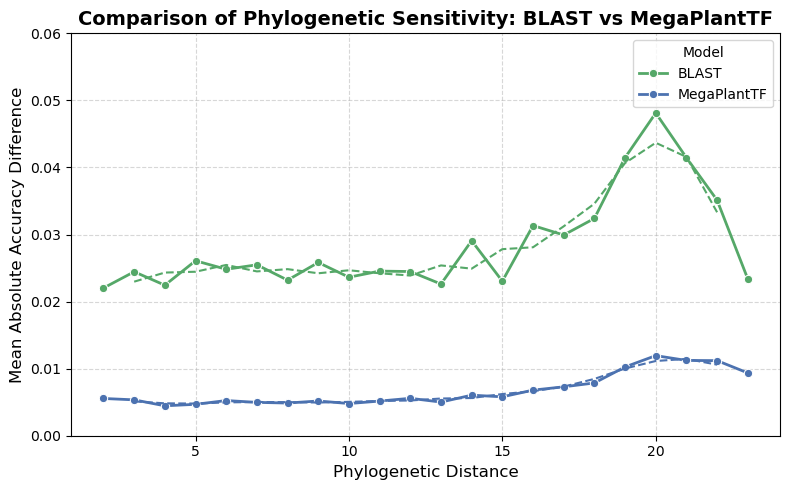

In [23]:
custom_palette = {
    "MegaPlantTF": "#4C72B0", 
    "BLAST": "#55A868"       
}

plt.figure(figsize=(8, 5))

# Main lineplot (solid)
sns.lineplot(
    data=combined_df,
    x="distance",
    y="accuracy_diff",
    hue="model",
    marker="o",
    linewidth=2,
    palette=custom_palette
)

# Optional smoothed trendlines (dashed, same colors)
sns.lineplot(
    data=combined_df,
    x="distance",
    y="smooth",
    hue="model",
    linestyle="--",
    palette=custom_palette,
    legend=False  # prevents duplicate legend
)

# --- Labels and style ---
plt.title("Comparison of Phylogenetic Sensitivity: BLAST vs MegaPlantTF", fontsize=14, weight="bold")
plt.xlabel("Phylogenetic Distance", fontsize=12)
plt.ylabel("Mean Absolute Accuracy Difference", fontsize=12)
plt.ylim(0, 0.06)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", fontsize=10)
plt.tight_layout()

# --- Save figure ---
plt.savefig("./results/blast_vs_megaplanttf_phylo.png", dpi=600, bbox_inches="tight")
plt.savefig("./phylogenetic_analysis_comparison.png", dpi=600, bbox_inches="tight")
plt.show()
